In [33]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import joblib #add for storing

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
#from tqdm.notebook import tqdm
from tqdm import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [34]:
data = []

for root, subdirs, files in os.walk('dataset/letters'): #changed path #for Task 3: dataset/letters
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

100%|██████████| 100/100 [00:00<00:00, 206.95it/s]


In [36]:
print(data[0])

('O', array([[-0.23950293, -1.01422467],
       [-0.24587092, -1.01401569],
       [-0.22959696, -1.01471745],
       [-0.29835768, -1.00801536],
       [-0.35734863, -0.99912088],
       [-0.4177037 , -0.99097495],
       [-0.53749254, -0.95001838],
       [-0.64630913, -0.91537043],
       [-0.7161584 , -0.86476927],
       [-0.86074724, -0.78359175],
       [-0.89813293, -0.75304552],
       [-1.02259409, -0.69024178],
       [-1.13210829, -0.57207325],
       [-1.25128153, -0.46093523],
       [-1.31325644, -0.30854489],
       [-1.38560307, -0.11047209],
       [-1.42550132,  0.04752688],
       [-1.42545473,  0.22355198],
       [-1.43100873,  0.41149759],
       [-1.36487645,  0.66754167],
       [-1.31196968,  0.87661594],
       [-1.18640684,  1.04867752],
       [-0.90118548,  1.29511238],
       [-0.31657702,  1.51981334],
       [-0.0962445 ,  1.59608531],
       [-0.10504146,  1.57642868],
       [ 0.07584245,  1.59531548],
       [ 0.3070312 ,  1.53843485],
       [ 0.635

## Let's have a look at our data

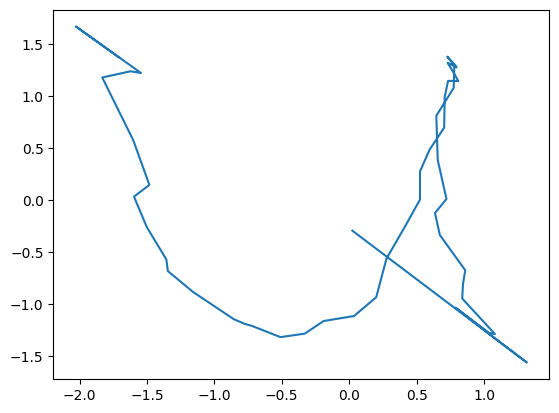

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x16552bce0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


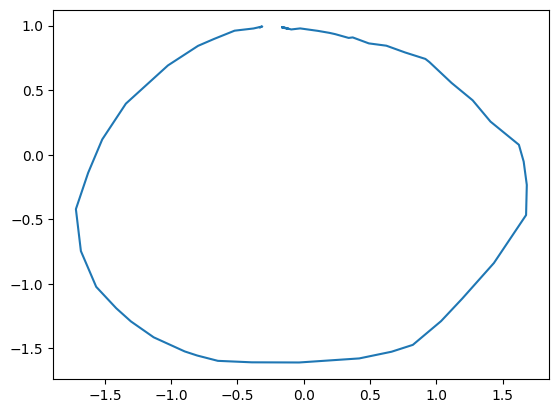

In [ ]:
test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

In [43]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
encoder.fit(labels)

joblib.dump(encoder, 'label_encoder.pkl') #label_encoder_letters.pkl for task 3

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# use whole Dataset for training
X_train = X
y_train = y

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'U', 'O', 'A', 'I', 'E'}
{0, 1, 2, 3, 4}
5


In [44]:
# Define the model
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates

# old syntax
#model.add(LSTM(64, input_shape=(NUM_POINTS, 2)))

# new syntax
model.add(Input((NUM_POINTS, 2)))
model.add(LSTM(64))
#model.add(LSTM(32))
#model.add(LSTM(16)) #reduce neurons here

# add dense layer to do machine learning magic
model.add(Dense(32, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance

# softmax layer for classification
model.add(Dense(len(set(labels)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [45]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    #validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.2559 - loss: 1.5909 - learning_rate: 0.0010
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4932 - loss: 1.5175 - learning_rate: 0.0010
Epoch 3/10


/Users/emmasophie/Desktop/Studium/Master/2. Semester/ITT/7. Gesture Recognition/assignment-6-gesture-recognition-EmmaSophieReichert/env/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/Users/emmasophie/Desktop/Studium/Master/2. Semester/ITT/7. Gesture Recognition/assignment-6-gesture-recognition-EmmaSophieReichert/env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5792 - loss: 1.4463 - learning_rate: 0.0010
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6220 - loss: 1.3800 - learning_rate: 0.0010
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6659 - loss: 1.2915 - learning_rate: 0.0010
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7465 - loss: 1.1755 - learning_rate: 0.0010
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7163 - loss: 1.0565 - learning_rate: 0.0010
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7161 - loss: 0.9350 - learning_rate: 0.0010
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7132 - loss: 0.7962 - learning_rate: 0.0010
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7008 - loss: 0.6737 - learning_rate: 0.0010


In [46]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,193 (227.32 KB)

 Trainable params: 19,397 (75.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,796 (151.55 KB)

In [47]:
#change here for storing

model.save('models/gesture_64_neurons.keras')
#model.save('models/gesture_32_neurons.keras')
#model.save('models/gesture_16_neurons.keras')

#model.save('models/letters.keras') #for task 3


In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

KeyError: 'val_loss'

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


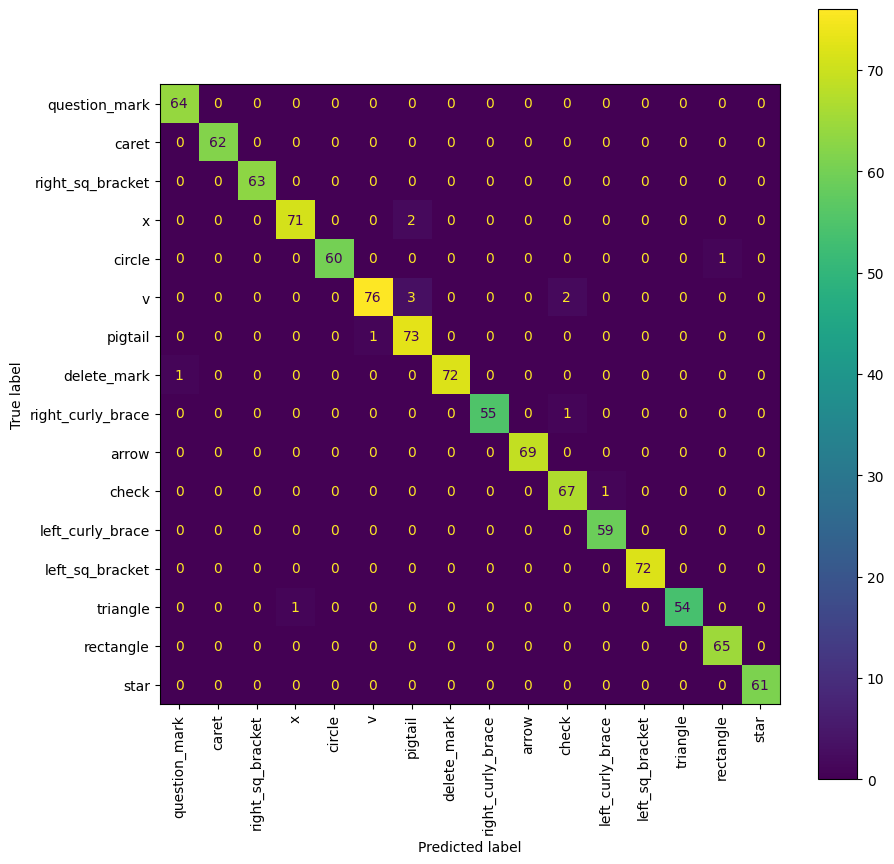

In [32]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Label:      left_curly_brace
Prediction: left_curly_brace


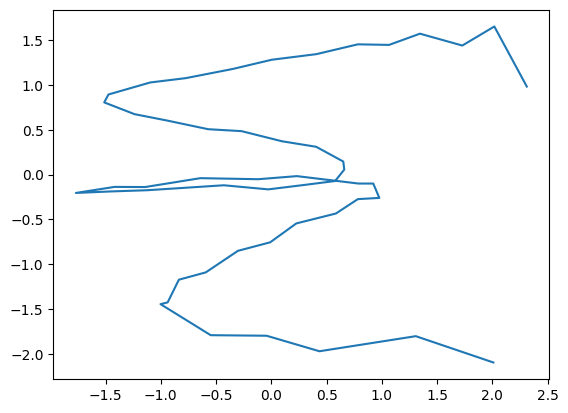

In [30]:
# lets test the model in action

test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)